#############################
#############################
##### importing packages ######
#############################
#############################

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
import math
import random

#############################
#############################
###### Data loading #########
#############################
#############################

In [30]:
random.seed(369)

dataset = pd.ExcelFile('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
data = dataset.parse(0) #getting the first Excel sheet

# checking if the data has been loaded correctly:
data.head() 


#this looks good, but I'd like to see all the columns:
pd.set_option('display.max_columns', 500)
data.head()
data.tail()


#this looks allright, but let's check if all the rows have been loaded:
data.shape # 541.909 rows. This is correct

(541909, 8)

#############################
#############################
###### Data munging #########
#############################
#############################

In [31]:
# let's first check if all the fields are in the right format, at least the most relevant ones:
# Quantity, UnitPrice, InvoiceDate
data.info() #invoicedate is a datetime variable, UnitPrice is a float, Quantiy is an integer --> this looks all right


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [32]:
#let's get a sense of what the data distribution looks like:
perc =[0.01,.05, .25, .50, .75, .95,0.99] 
data.describe(perc) 
# the unit price of most of the items seems to be below 18€ and the quantities ordered below 100 units
# there seem to be some extreme values, which could be outliers (e.g. 38970€ unit price)
# some of these orders with extreme values could be real orders that have been cancelled afterwards
#they could be data entry errors.... for now we won't remove them

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
1%,-2.000000,0.190000,12415.000000
5%,1.000000,0.420000,12626.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
95%,29.000000,9.950000,17905.000000


In [33]:
#let's now check if there is any missing data in the relevant columns
data['Quantity'].isnull().values.any()

False

In [34]:
data['UnitPrice'].isnull().values.any()

False

In [35]:
# As we're trying to predict the daily salesm, we'll have to multiply the UnitPrice by the Quantity:
data['Amount'] = data['Quantity'] * data['UnitPrice']
 

# let's now strip the hours and minutes from the InvoiceDate:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'].dt.date, format='%Y-%m-%d')


# we're now removing the columns that we're not interested in. For this simple model we'll just consider the InvoiceDate and the Amount
data = data.loc[:,['InvoiceDate','Amount']]


#let's now group and sum up the sales amount by date 
data = data.groupby('InvoiceDate').sum()


data.head()
# the data is already sorted chronogically
# we can see that some days are missing 
# it also seems that the shop was closed during Christmas, at least between December 24th and January 3rd 2010
# For the sake of simplicity and as there is quite a big time gap for the Christmas data, we'll get rid of the data from 2010

reducedDates = data.index > '2011-01-01'
data = data[reducedDates]

#############################
#############################
###### Data Modelling #######
#############################
#############################

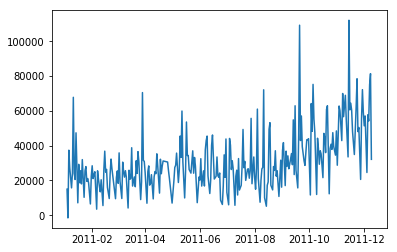

In [36]:
#let's plot the data:
plt.plot(data)

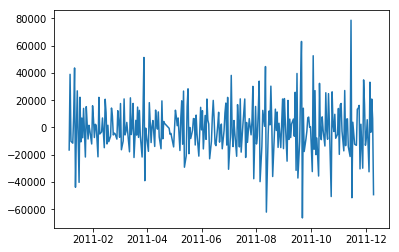

In [37]:
#As there is only one year of data, it's hard to tell if there is yearly seasonality
# It would seem that the sales increased after August. This could be some sort of trend reversal or maybe just due to Christmas (in November and December).
# We can also see several sudden "spikes" that might have been caused by specific sales or marketing campaigns, although this is relatively hard to tell at an aggregated level

# Normally differencing this time series would be avisable, in order to make it stationary.
# If we calculate the first lag difference, we get this:

plt.plot(data['Amount'].diff(periods=1))

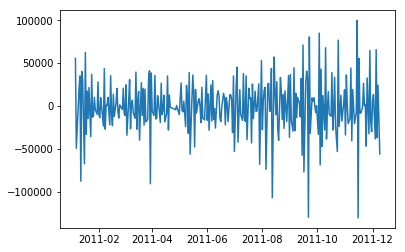

In [38]:
# Well, unfortunately this doesn't look very stationary either. More "traditional" forecasting techniques like ARIMA or other autoregressive modeling techniques would most likely not be applicable here 
# due to the time depency seen in the sales pattern. 
# Even differencing the time series twice doesn't solve the issue either: 
plt.plot(data['Amount'].diff(periods=1).diff(periods=1))

In [39]:
###### LSTM ######### 

# Recurrent Neural Networks can be used for time series forecasting. 
# One of the advantages of recurrent networks, especially LSTM, is that they can deal with non-stationary.
# Here you have some more information: https://datascience.stackexchange.com/questions/24800/time-series-prediction-using-lstms-importance-of-making-time-series-stationary 


# In order to be able to assess how well the model predicts future values, we'll split the dataset into a training and a test set:

train, test = train_test_split(data['Amount'].values, shuffle=False, test_size=0.2)


In [40]:

#LSTM works better when the input features have been normalized. Let's do that:
scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(data['Amount'].values.reshape(-1,1))

train = scaler.fit_transform(train.reshape(-1,1))
test = scaler.transform(test.reshape(-1,1))

In [41]:
# Let's first reshape the dataset to make it usable for LSTM.
# LSTM looks back at past data points in order to predict "future" data points.
# this function gets our data into the right shape:
# We're predicting the sales volume ("Target") based on the 



def reshape_data(mydata, past_data_points):
    mydataX, mydataY = [], []
    for i in range(len(mydata)-past_data_points-1):
        dependent_variables = mydata[i:(i+past_data_points)]
        mydataX.append(dependent_variables)
        mydataY.append(mydata[i + past_data_points])
    return np.array(mydataX), np.array(mydataY)



#let's try it with looking back 3 days:

history = 3    
    
dependentTrain, targetTrain = reshape_data(train, history)
dependentTest, targetTest = reshape_data(test, history)

# reshape input to be [samples, time steps, features]
dependentTrain = np.reshape(dependentTrain, (dependentTrain.shape[0], 1, dependentTrain.shape[1]))
dependentTest = np.reshape(dependentTest, (dependentTest.shape[0], 1, dependentTest.shape[1]))

# Fitting the neural network:
model1 = Sequential()
model1.add(LSTM(5, input_shape=(1, history),stateful=False))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.fit(dependentTrain, targetTrain, epochs=1000, batch_size=15, verbose=2, validation_data=(dependentTest, targetTest), shuffle=False)

model1.evaluate(dependentTest, targetTest, batch_size=30, verbose=0)



# the network stops learning after a certain number of Epochs.

Train on 224 samples, validate on 53 samples
Epoch 1/1000
 - 0s - loss: 0.1167 - val_loss: 0.3237
Epoch 2/1000
 - 0s - loss: 0.0933 - val_loss: 0.2739
Epoch 3/1000
 - 0s - loss: 0.0740 - val_loss: 0.2311
Epoch 4/1000
 - 0s - loss: 0.0584 - val_loss: 0.1944
Epoch 5/1000
 - 0s - loss: 0.0459 - val_loss: 0.1630
Epoch 6/1000
 - 0s - loss: 0.0361 - val_loss: 0.1366
Epoch 7/1000
 - 0s - loss: 0.0288 - val_loss: 0.1148
Epoch 8/1000
 - 0s - loss: 0.0236 - val_loss: 0.0972
Epoch 9/1000
 - 0s - loss: 0.0201 - val_loss: 0.0836
Epoch 10/1000
 - 0s - loss: 0.0179 - val_loss: 0.0735
Epoch 11/1000
 - 0s - loss: 0.0167 - val_loss: 0.0661
Epoch 12/1000
 - 0s - loss: 0.0161 - val_loss: 0.0610
Epoch 13/1000
 - 0s - loss: 0.0158 - val_loss: 0.0576
Epoch 14/1000
 - 0s - loss: 0.0157 - val_loss: 0.0554
Epoch 15/1000
 - 0s - loss: 0.0156 - val_loss: 0.0540
Epoch 16/1000
 - 0s - loss: 0.0156 - val_loss: 0.0532
Epoch 17/1000
 - 0s - loss: 0.0156 - val_loss: 0.0528
Epoch 18/1000
 - 0s - loss: 0.0156 - val_loss:

 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 152/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 153/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 154/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 155/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 156/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 157/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 158/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 159/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 160/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 161/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 162/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 163/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 164/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 165/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 166/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 167/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 168/1000
 - 0s - loss: 0.0153 - val_loss: 0.0517
Epoch 169/1000
 - 0s - lo

Epoch 301/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 302/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 303/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 304/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 305/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 306/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 307/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 308/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 309/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 310/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 311/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 312/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 313/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 314/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 315/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 316/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 317/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 318/1000
 - 0s - loss: 0.0152 - val_loss: 0.0515
Epoch 319/

Epoch 450/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 451/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 452/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 453/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 454/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 455/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 456/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 457/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 458/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 459/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 460/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 461/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 462/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 463/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 464/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 465/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 466/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 467/1000
 - 0s - loss: 0.0152 - val_loss: 0.0514
Epoch 468/

Epoch 599/1000
 - 0s - loss: 0.0151 - val_loss: 0.0513
Epoch 600/1000
 - 0s - loss: 0.0151 - val_loss: 0.0513
Epoch 601/1000
 - 0s - loss: 0.0151 - val_loss: 0.0513
Epoch 602/1000
 - 0s - loss: 0.0151 - val_loss: 0.0513
Epoch 603/1000
 - 0s - loss: 0.0151 - val_loss: 0.0513
Epoch 604/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 605/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 606/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 607/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 608/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 609/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 610/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 611/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 612/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 613/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 614/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 615/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 616/1000
 - 0s - loss: 0.0151 - val_loss: 0.0512
Epoch 617/

Epoch 748/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 749/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 750/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 751/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 752/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 753/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 754/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 755/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 756/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 757/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 758/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 759/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 760/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 761/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 762/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 763/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 764/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 765/1000
 - 0s - loss: 0.0151 - val_loss: 0.0510
Epoch 766/

Epoch 897/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 898/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 899/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 900/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 901/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 902/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 903/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 904/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 905/1000
 - 0s - loss: 0.0151 - val_loss: 0.0507
Epoch 906/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 907/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 908/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 909/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 910/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 911/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 912/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 913/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 914/1000
 - 0s - loss: 0.0151 - val_loss: 0.0506
Epoch 915/

0.050428786648894254

In [42]:
# as LSTM can learn long-term dependencies, let's see what happens if we look back 10 days:     
history = 10

dependentTrain, targetTrain = reshape_data(train, history)
dependentTest, targetTest = reshape_data(test, history)

# reshape input to be [samples, time steps, features]
dependentTrain = np.reshape(dependentTrain, (dependentTrain.shape[0], 1, dependentTrain.shape[1]))
dependentTest = np.reshape(dependentTest, (dependentTest.shape[0], 1, dependentTest.shape[1]))

# Fitting the neural network:
model2 = Sequential()
model2.add(LSTM(5, input_shape=(1, history),stateful=False))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(dependentTrain, targetTrain, epochs=1000, batch_size=30, verbose=2, validation_data=(dependentTest, targetTest), shuffle=False)

model2.evaluate(dependentTest, targetTest, batch_size=30, verbose=0)

Train on 217 samples, validate on 46 samples
Epoch 1/1000
 - 0s - loss: 0.1131 - val_loss: 0.3423
Epoch 2/1000
 - 0s - loss: 0.0955 - val_loss: 0.2968
Epoch 3/1000
 - 0s - loss: 0.0803 - val_loss: 0.2557
Epoch 4/1000
 - 0s - loss: 0.0672 - val_loss: 0.2191
Epoch 5/1000
 - 0s - loss: 0.0559 - val_loss: 0.1868
Epoch 6/1000
 - 0s - loss: 0.0464 - val_loss: 0.1585
Epoch 7/1000
 - 0s - loss: 0.0385 - val_loss: 0.1340
Epoch 8/1000
 - 0s - loss: 0.0321 - val_loss: 0.1132
Epoch 9/1000
 - 0s - loss: 0.0271 - val_loss: 0.0958
Epoch 10/1000
 - 0s - loss: 0.0232 - val_loss: 0.0814
Epoch 11/1000
 - 0s - loss: 0.0204 - val_loss: 0.0699
Epoch 12/1000
 - 0s - loss: 0.0184 - val_loss: 0.0609
Epoch 13/1000
 - 0s - loss: 0.0170 - val_loss: 0.0540
Epoch 14/1000
 - 0s - loss: 0.0162 - val_loss: 0.0488
Epoch 15/1000
 - 0s - loss: 0.0157 - val_loss: 0.0450
Epoch 16/1000
 - 0s - loss: 0.0154 - val_loss: 0.0423
Epoch 17/1000
 - 0s - loss: 0.0153 - val_loss: 0.0404
Epoch 18/1000
 - 0s - loss: 0.0152 - val_loss:

Epoch 152/1000
 - 0s - loss: 0.0119 - val_loss: 0.0376
Epoch 153/1000
 - 0s - loss: 0.0119 - val_loss: 0.0376
Epoch 154/1000
 - 0s - loss: 0.0119 - val_loss: 0.0376
Epoch 155/1000
 - 0s - loss: 0.0119 - val_loss: 0.0376
Epoch 156/1000
 - 0s - loss: 0.0119 - val_loss: 0.0376
Epoch 157/1000
 - 0s - loss: 0.0119 - val_loss: 0.0376
Epoch 158/1000
 - 0s - loss: 0.0119 - val_loss: 0.0376
Epoch 159/1000
 - 0s - loss: 0.0118 - val_loss: 0.0376
Epoch 160/1000
 - 0s - loss: 0.0118 - val_loss: 0.0376
Epoch 161/1000
 - 0s - loss: 0.0118 - val_loss: 0.0376
Epoch 162/1000
 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 163/1000
 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 164/1000
 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 165/1000
 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 166/1000
 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 167/1000
 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 168/1000
 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 169/1000
 - 0s - loss: 0.0118 - val_loss: 0.0375
Epoch 170/

Epoch 301/1000
 - 0s - loss: 0.0114 - val_loss: 0.0362
Epoch 302/1000
 - 0s - loss: 0.0114 - val_loss: 0.0362
Epoch 303/1000
 - 0s - loss: 0.0114 - val_loss: 0.0362
Epoch 304/1000
 - 0s - loss: 0.0114 - val_loss: 0.0361
Epoch 305/1000
 - 0s - loss: 0.0114 - val_loss: 0.0361
Epoch 306/1000
 - 0s - loss: 0.0114 - val_loss: 0.0361
Epoch 307/1000
 - 0s - loss: 0.0114 - val_loss: 0.0361
Epoch 308/1000
 - 0s - loss: 0.0114 - val_loss: 0.0361
Epoch 309/1000
 - 0s - loss: 0.0114 - val_loss: 0.0361
Epoch 310/1000
 - 0s - loss: 0.0114 - val_loss: 0.0361
Epoch 311/1000
 - 0s - loss: 0.0114 - val_loss: 0.0360
Epoch 312/1000
 - 0s - loss: 0.0114 - val_loss: 0.0360
Epoch 313/1000
 - 0s - loss: 0.0114 - val_loss: 0.0360
Epoch 314/1000
 - 0s - loss: 0.0114 - val_loss: 0.0360
Epoch 315/1000
 - 0s - loss: 0.0114 - val_loss: 0.0360
Epoch 316/1000
 - 0s - loss: 0.0114 - val_loss: 0.0360
Epoch 317/1000
 - 0s - loss: 0.0114 - val_loss: 0.0360
Epoch 318/1000
 - 0s - loss: 0.0114 - val_loss: 0.0360
Epoch 319/

Epoch 450/1000
 - 0s - loss: 0.0110 - val_loss: 0.0338
Epoch 451/1000
 - 0s - loss: 0.0110 - val_loss: 0.0338
Epoch 452/1000
 - 0s - loss: 0.0110 - val_loss: 0.0337
Epoch 453/1000
 - 0s - loss: 0.0110 - val_loss: 0.0337
Epoch 454/1000
 - 0s - loss: 0.0110 - val_loss: 0.0337
Epoch 455/1000
 - 0s - loss: 0.0110 - val_loss: 0.0337
Epoch 456/1000
 - 0s - loss: 0.0110 - val_loss: 0.0337
Epoch 457/1000
 - 0s - loss: 0.0110 - val_loss: 0.0336
Epoch 458/1000
 - 0s - loss: 0.0110 - val_loss: 0.0336
Epoch 459/1000
 - 0s - loss: 0.0110 - val_loss: 0.0336
Epoch 460/1000
 - 0s - loss: 0.0110 - val_loss: 0.0336
Epoch 461/1000
 - 0s - loss: 0.0110 - val_loss: 0.0336
Epoch 462/1000
 - 0s - loss: 0.0110 - val_loss: 0.0336
Epoch 463/1000
 - 0s - loss: 0.0110 - val_loss: 0.0335
Epoch 464/1000
 - 0s - loss: 0.0110 - val_loss: 0.0335
Epoch 465/1000
 - 0s - loss: 0.0110 - val_loss: 0.0335
Epoch 466/1000
 - 0s - loss: 0.0110 - val_loss: 0.0335
Epoch 467/1000
 - 0s - loss: 0.0110 - val_loss: 0.0335
Epoch 468/

Epoch 599/1000
 - 0s - loss: 0.0106 - val_loss: 0.0310
Epoch 600/1000
 - 0s - loss: 0.0106 - val_loss: 0.0310
Epoch 601/1000
 - 0s - loss: 0.0106 - val_loss: 0.0310
Epoch 602/1000
 - 0s - loss: 0.0106 - val_loss: 0.0309
Epoch 603/1000
 - 0s - loss: 0.0106 - val_loss: 0.0309
Epoch 604/1000
 - 0s - loss: 0.0106 - val_loss: 0.0309
Epoch 605/1000
 - 0s - loss: 0.0106 - val_loss: 0.0309
Epoch 606/1000
 - 0s - loss: 0.0106 - val_loss: 0.0309
Epoch 607/1000
 - 0s - loss: 0.0106 - val_loss: 0.0308
Epoch 608/1000
 - 0s - loss: 0.0106 - val_loss: 0.0308
Epoch 609/1000
 - 0s - loss: 0.0106 - val_loss: 0.0308
Epoch 610/1000
 - 0s - loss: 0.0106 - val_loss: 0.0308
Epoch 611/1000
 - 0s - loss: 0.0106 - val_loss: 0.0308
Epoch 612/1000
 - 0s - loss: 0.0106 - val_loss: 0.0308
Epoch 613/1000
 - 0s - loss: 0.0106 - val_loss: 0.0307
Epoch 614/1000
 - 0s - loss: 0.0106 - val_loss: 0.0307
Epoch 615/1000
 - 0s - loss: 0.0106 - val_loss: 0.0307
Epoch 616/1000
 - 0s - loss: 0.0106 - val_loss: 0.0307
Epoch 617/

Epoch 748/1000
 - 0s - loss: 0.0103 - val_loss: 0.0286
Epoch 749/1000
 - 0s - loss: 0.0103 - val_loss: 0.0286
Epoch 750/1000
 - 0s - loss: 0.0103 - val_loss: 0.0286
Epoch 751/1000
 - 0s - loss: 0.0103 - val_loss: 0.0286
Epoch 752/1000
 - 0s - loss: 0.0103 - val_loss: 0.0285
Epoch 753/1000
 - 0s - loss: 0.0103 - val_loss: 0.0285
Epoch 754/1000
 - 0s - loss: 0.0103 - val_loss: 0.0285
Epoch 755/1000
 - 0s - loss: 0.0103 - val_loss: 0.0285
Epoch 756/1000
 - 0s - loss: 0.0103 - val_loss: 0.0285
Epoch 757/1000
 - 0s - loss: 0.0103 - val_loss: 0.0285
Epoch 758/1000
 - 0s - loss: 0.0103 - val_loss: 0.0285
Epoch 759/1000
 - 0s - loss: 0.0103 - val_loss: 0.0285
Epoch 760/1000
 - 0s - loss: 0.0103 - val_loss: 0.0284
Epoch 761/1000
 - 0s - loss: 0.0103 - val_loss: 0.0284
Epoch 762/1000
 - 0s - loss: 0.0103 - val_loss: 0.0284
Epoch 763/1000
 - 0s - loss: 0.0103 - val_loss: 0.0284
Epoch 764/1000
 - 0s - loss: 0.0103 - val_loss: 0.0284
Epoch 765/1000
 - 0s - loss: 0.0103 - val_loss: 0.0284
Epoch 766/

Epoch 897/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 898/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 899/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 900/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 901/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 902/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 903/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 904/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 905/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 906/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 907/1000
 - 0s - loss: 0.0101 - val_loss: 0.0272
Epoch 908/1000
 - 0s - loss: 0.0101 - val_loss: 0.0271
Epoch 909/1000
 - 0s - loss: 0.0101 - val_loss: 0.0271
Epoch 910/1000
 - 0s - loss: 0.0101 - val_loss: 0.0271
Epoch 911/1000
 - 0s - loss: 0.0101 - val_loss: 0.0271
Epoch 912/1000
 - 0s - loss: 0.0101 - val_loss: 0.0271
Epoch 913/1000
 - 0s - loss: 0.0101 - val_loss: 0.0271
Epoch 914/1000
 - 0s - loss: 0.0101 - val_loss: 0.0271
Epoch 915/

0.026888645537521527

In [43]:
# this looks much better - the MSE is much lower, for the training set as well as for the validation dataset
# But what happens if we add more neurons, let's say 10?

history = 10
dependentTrain, targetTrain = reshape_data(train, history)
dependentTest, targetTest = reshape_data(test, history)

# reshape input to be [samples, time steps, features]
dependentTrain = np.reshape(dependentTrain, (dependentTrain.shape[0], 1, dependentTrain.shape[1]))
dependentTest = np.reshape(dependentTest, (dependentTest.shape[0], 1, dependentTest.shape[1]))

# Fitting the neural network:
model3 = Sequential()
model3.add(LSTM(10, input_shape=(1, history),stateful=False))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(dependentTrain, targetTrain, epochs=1000, batch_size=30, verbose=2, validation_data=(dependentTest, targetTest), shuffle=False)

model3.evaluate(dependentTest, targetTest, batch_size=30, verbose=0)

Train on 217 samples, validate on 46 samples
Epoch 1/1000
 - 0s - loss: 0.0705 - val_loss: 0.1987
Epoch 2/1000
 - 0s - loss: 0.0544 - val_loss: 0.1565
Epoch 3/1000
 - 0s - loss: 0.0414 - val_loss: 0.1208
Epoch 4/1000
 - 0s - loss: 0.0312 - val_loss: 0.0915
Epoch 5/1000
 - 0s - loss: 0.0236 - val_loss: 0.0686
Epoch 6/1000
 - 0s - loss: 0.0186 - val_loss: 0.0519
Epoch 7/1000
 - 0s - loss: 0.0156 - val_loss: 0.0407
Epoch 8/1000
 - 0s - loss: 0.0141 - val_loss: 0.0340
Epoch 9/1000
 - 0s - loss: 0.0136 - val_loss: 0.0303
Epoch 10/1000
 - 0s - loss: 0.0135 - val_loss: 0.0287
Epoch 11/1000
 - 0s - loss: 0.0135 - val_loss: 0.0282
Epoch 12/1000
 - 0s - loss: 0.0135 - val_loss: 0.0284
Epoch 13/1000
 - 0s - loss: 0.0135 - val_loss: 0.0288
Epoch 14/1000
 - 0s - loss: 0.0135 - val_loss: 0.0292
Epoch 15/1000
 - 0s - loss: 0.0134 - val_loss: 0.0296
Epoch 16/1000
 - 0s - loss: 0.0134 - val_loss: 0.0298
Epoch 17/1000
 - 0s - loss: 0.0134 - val_loss: 0.0299
Epoch 18/1000
 - 0s - loss: 0.0133 - val_loss:

Epoch 152/1000
 - 0s - loss: 0.0116 - val_loss: 0.0336
Epoch 153/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 154/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 155/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 156/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 157/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 158/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 159/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 160/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 161/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 162/1000
 - 0s - loss: 0.0115 - val_loss: 0.0336
Epoch 163/1000
 - 0s - loss: 0.0115 - val_loss: 0.0335
Epoch 164/1000
 - 0s - loss: 0.0115 - val_loss: 0.0335
Epoch 165/1000
 - 0s - loss: 0.0115 - val_loss: 0.0335
Epoch 166/1000
 - 0s - loss: 0.0115 - val_loss: 0.0335
Epoch 167/1000
 - 0s - loss: 0.0115 - val_loss: 0.0335
Epoch 168/1000
 - 0s - loss: 0.0115 - val_loss: 0.0335
Epoch 169/1000
 - 0s - loss: 0.0115 - val_loss: 0.0335
Epoch 170/

Epoch 301/1000
 - 0s - loss: 0.0111 - val_loss: 0.0313
Epoch 302/1000
 - 0s - loss: 0.0111 - val_loss: 0.0313
Epoch 303/1000
 - 0s - loss: 0.0111 - val_loss: 0.0313
Epoch 304/1000
 - 0s - loss: 0.0111 - val_loss: 0.0312
Epoch 305/1000
 - 0s - loss: 0.0111 - val_loss: 0.0312
Epoch 306/1000
 - 0s - loss: 0.0111 - val_loss: 0.0312
Epoch 307/1000
 - 0s - loss: 0.0111 - val_loss: 0.0312
Epoch 308/1000
 - 0s - loss: 0.0111 - val_loss: 0.0311
Epoch 309/1000
 - 0s - loss: 0.0111 - val_loss: 0.0311
Epoch 310/1000
 - 0s - loss: 0.0111 - val_loss: 0.0311
Epoch 311/1000
 - 0s - loss: 0.0111 - val_loss: 0.0311
Epoch 312/1000
 - 0s - loss: 0.0111 - val_loss: 0.0311
Epoch 313/1000
 - 0s - loss: 0.0111 - val_loss: 0.0310
Epoch 314/1000
 - 0s - loss: 0.0111 - val_loss: 0.0310
Epoch 315/1000
 - 0s - loss: 0.0111 - val_loss: 0.0310
Epoch 316/1000
 - 0s - loss: 0.0110 - val_loss: 0.0310
Epoch 317/1000
 - 0s - loss: 0.0110 - val_loss: 0.0309
Epoch 318/1000
 - 0s - loss: 0.0110 - val_loss: 0.0309
Epoch 319/

Epoch 450/1000
 - 0s - loss: 0.0106 - val_loss: 0.0279
Epoch 451/1000
 - 0s - loss: 0.0106 - val_loss: 0.0279
Epoch 452/1000
 - 0s - loss: 0.0106 - val_loss: 0.0278
Epoch 453/1000
 - 0s - loss: 0.0106 - val_loss: 0.0278
Epoch 454/1000
 - 0s - loss: 0.0106 - val_loss: 0.0278
Epoch 455/1000
 - 0s - loss: 0.0106 - val_loss: 0.0278
Epoch 456/1000
 - 0s - loss: 0.0106 - val_loss: 0.0278
Epoch 457/1000
 - 0s - loss: 0.0106 - val_loss: 0.0277
Epoch 458/1000
 - 0s - loss: 0.0106 - val_loss: 0.0277
Epoch 459/1000
 - 0s - loss: 0.0106 - val_loss: 0.0277
Epoch 460/1000
 - 0s - loss: 0.0106 - val_loss: 0.0277
Epoch 461/1000
 - 0s - loss: 0.0106 - val_loss: 0.0276
Epoch 462/1000
 - 0s - loss: 0.0106 - val_loss: 0.0276
Epoch 463/1000
 - 0s - loss: 0.0106 - val_loss: 0.0276
Epoch 464/1000
 - 0s - loss: 0.0106 - val_loss: 0.0276
Epoch 465/1000
 - 0s - loss: 0.0106 - val_loss: 0.0276
Epoch 466/1000
 - 0s - loss: 0.0106 - val_loss: 0.0275
Epoch 467/1000
 - 0s - loss: 0.0106 - val_loss: 0.0275
Epoch 468/

Epoch 599/1000
 - 0s - loss: 0.0103 - val_loss: 0.0251
Epoch 600/1000
 - 0s - loss: 0.0103 - val_loss: 0.0251
Epoch 601/1000
 - 0s - loss: 0.0103 - val_loss: 0.0251
Epoch 602/1000
 - 0s - loss: 0.0103 - val_loss: 0.0251
Epoch 603/1000
 - 0s - loss: 0.0103 - val_loss: 0.0251
Epoch 604/1000
 - 0s - loss: 0.0103 - val_loss: 0.0251
Epoch 605/1000
 - 0s - loss: 0.0103 - val_loss: 0.0250
Epoch 606/1000
 - 0s - loss: 0.0103 - val_loss: 0.0250
Epoch 607/1000
 - 0s - loss: 0.0103 - val_loss: 0.0250
Epoch 608/1000
 - 0s - loss: 0.0103 - val_loss: 0.0250
Epoch 609/1000
 - 0s - loss: 0.0103 - val_loss: 0.0250
Epoch 610/1000
 - 0s - loss: 0.0103 - val_loss: 0.0250
Epoch 611/1000
 - 0s - loss: 0.0103 - val_loss: 0.0250
Epoch 612/1000
 - 0s - loss: 0.0103 - val_loss: 0.0250
Epoch 613/1000
 - 0s - loss: 0.0103 - val_loss: 0.0249
Epoch 614/1000
 - 0s - loss: 0.0103 - val_loss: 0.0249
Epoch 615/1000
 - 0s - loss: 0.0103 - val_loss: 0.0249
Epoch 616/1000
 - 0s - loss: 0.0103 - val_loss: 0.0249
Epoch 617/

Epoch 748/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 749/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 750/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 751/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 752/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 753/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 754/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 755/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 756/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 757/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 758/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 759/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 760/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 761/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 762/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 763/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 764/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 765/1000
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 766/

Epoch 897/1000
 - 0s - loss: 0.0097 - val_loss: 0.0242
Epoch 898/1000
 - 0s - loss: 0.0097 - val_loss: 0.0242
Epoch 899/1000
 - 0s - loss: 0.0097 - val_loss: 0.0242
Epoch 900/1000
 - 0s - loss: 0.0097 - val_loss: 0.0242
Epoch 901/1000
 - 0s - loss: 0.0097 - val_loss: 0.0242
Epoch 902/1000
 - 0s - loss: 0.0097 - val_loss: 0.0242
Epoch 903/1000
 - 0s - loss: 0.0097 - val_loss: 0.0242
Epoch 904/1000
 - 0s - loss: 0.0097 - val_loss: 0.0243
Epoch 905/1000
 - 0s - loss: 0.0097 - val_loss: 0.0243
Epoch 906/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 907/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 908/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 909/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 910/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 911/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 912/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 913/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 914/1000
 - 0s - loss: 0.0096 - val_loss: 0.0243
Epoch 915/

0.025340232917148132

In [44]:
# this seems to reduce the MSE, 
# We can also try to add another layer:

history = 10
dependentTrain, targetTrain = reshape_data(train, history)
dependentTest, targetTest = reshape_data(test, history)

# reshape input to be [samples, time steps, features]
dependentTrain = np.reshape(dependentTrain, (dependentTrain.shape[0], 1, dependentTrain.shape[1]))
dependentTest = np.reshape(dependentTest, (dependentTest.shape[0], 1, dependentTest.shape[1]))

# Fitting the neural network:
model4 = Sequential()
model4.add(LSTM(10, input_shape=(1, history),stateful=False, return_sequences=True))
model4.add(LSTM(10))
model4.add(Dense(1))
model4.compile(loss='mean_squared_error', optimizer='adam')
model4.fit(dependentTrain, targetTrain, epochs=1000, batch_size=30, verbose=2, validation_data=(dependentTest, targetTest), shuffle=False)

model4.evaluate(dependentTest, targetTest, batch_size=30, verbose=0)

# This doesn't seem to reduce the MSE. 
# We could try to tweak the network parameters, not only the number of layers but also the open rates, etc: https://keras.io/optimizers/
# But this probably exceeds the purpose of this demo. Let's use model 3 bceause it has the lowest MSE for the test dataset (although we might be overfitting....)


Train on 217 samples, validate on 46 samples
Epoch 1/1000
 - 1s - loss: 0.0780 - val_loss: 0.2427
Epoch 2/1000
 - 0s - loss: 0.0647 - val_loss: 0.2121
Epoch 3/1000
 - 0s - loss: 0.0532 - val_loss: 0.1840
Epoch 4/1000
 - 0s - loss: 0.0432 - val_loss: 0.1580
Epoch 5/1000
 - 0s - loss: 0.0346 - val_loss: 0.1341
Epoch 6/1000
 - 0s - loss: 0.0275 - val_loss: 0.1124
Epoch 7/1000
 - 0s - loss: 0.0220 - val_loss: 0.0934
Epoch 8/1000
 - 0s - loss: 0.0180 - val_loss: 0.0773
Epoch 9/1000
 - 0s - loss: 0.0156 - val_loss: 0.0647
Epoch 10/1000
 - 0s - loss: 0.0144 - val_loss: 0.0557
Epoch 11/1000
 - 0s - loss: 0.0140 - val_loss: 0.0499
Epoch 12/1000
 - 0s - loss: 0.0141 - val_loss: 0.0468
Epoch 13/1000
 - 0s - loss: 0.0141 - val_loss: 0.0457
Epoch 14/1000
 - 0s - loss: 0.0142 - val_loss: 0.0456
Epoch 15/1000
 - 0s - loss: 0.0142 - val_loss: 0.0460
Epoch 16/1000
 - 0s - loss: 0.0141 - val_loss: 0.0465
Epoch 17/1000
 - 0s - loss: 0.0141 - val_loss: 0.0467
Epoch 18/1000
 - 0s - loss: 0.0140 - val_loss:

Epoch 152/1000
 - 0s - loss: 0.0116 - val_loss: 0.0373
Epoch 153/1000
 - 0s - loss: 0.0116 - val_loss: 0.0373
Epoch 154/1000
 - 0s - loss: 0.0116 - val_loss: 0.0372
Epoch 155/1000
 - 0s - loss: 0.0116 - val_loss: 0.0372
Epoch 156/1000
 - 0s - loss: 0.0116 - val_loss: 0.0372
Epoch 157/1000
 - 0s - loss: 0.0116 - val_loss: 0.0372
Epoch 158/1000
 - 0s - loss: 0.0116 - val_loss: 0.0371
Epoch 159/1000
 - 0s - loss: 0.0116 - val_loss: 0.0371
Epoch 160/1000
 - 0s - loss: 0.0116 - val_loss: 0.0371
Epoch 161/1000
 - 0s - loss: 0.0116 - val_loss: 0.0370
Epoch 162/1000
 - 0s - loss: 0.0116 - val_loss: 0.0370
Epoch 163/1000
 - 0s - loss: 0.0116 - val_loss: 0.0370
Epoch 164/1000
 - 0s - loss: 0.0116 - val_loss: 0.0370
Epoch 165/1000
 - 0s - loss: 0.0116 - val_loss: 0.0369
Epoch 166/1000
 - 0s - loss: 0.0115 - val_loss: 0.0369
Epoch 167/1000
 - 0s - loss: 0.0115 - val_loss: 0.0369
Epoch 168/1000
 - 0s - loss: 0.0115 - val_loss: 0.0369
Epoch 169/1000
 - 0s - loss: 0.0115 - val_loss: 0.0368
Epoch 170/

Epoch 301/1000
 - 0s - loss: 0.0110 - val_loss: 0.0330
Epoch 302/1000
 - 0s - loss: 0.0110 - val_loss: 0.0330
Epoch 303/1000
 - 0s - loss: 0.0110 - val_loss: 0.0330
Epoch 304/1000
 - 0s - loss: 0.0109 - val_loss: 0.0329
Epoch 305/1000
 - 0s - loss: 0.0109 - val_loss: 0.0329
Epoch 306/1000
 - 0s - loss: 0.0109 - val_loss: 0.0329
Epoch 307/1000
 - 0s - loss: 0.0109 - val_loss: 0.0329
Epoch 308/1000
 - 0s - loss: 0.0109 - val_loss: 0.0328
Epoch 309/1000
 - 0s - loss: 0.0109 - val_loss: 0.0328
Epoch 310/1000
 - 0s - loss: 0.0109 - val_loss: 0.0328
Epoch 311/1000
 - 0s - loss: 0.0109 - val_loss: 0.0327
Epoch 312/1000
 - 0s - loss: 0.0109 - val_loss: 0.0327
Epoch 313/1000
 - 0s - loss: 0.0109 - val_loss: 0.0327
Epoch 314/1000
 - 0s - loss: 0.0109 - val_loss: 0.0326
Epoch 315/1000
 - 0s - loss: 0.0109 - val_loss: 0.0326
Epoch 316/1000
 - 0s - loss: 0.0109 - val_loss: 0.0326
Epoch 317/1000
 - 0s - loss: 0.0109 - val_loss: 0.0326
Epoch 318/1000
 - 0s - loss: 0.0109 - val_loss: 0.0325
Epoch 319/

Epoch 450/1000
 - 0s - loss: 0.0105 - val_loss: 0.0288
Epoch 451/1000
 - 0s - loss: 0.0105 - val_loss: 0.0288
Epoch 452/1000
 - 0s - loss: 0.0105 - val_loss: 0.0287
Epoch 453/1000
 - 0s - loss: 0.0105 - val_loss: 0.0287
Epoch 454/1000
 - 0s - loss: 0.0105 - val_loss: 0.0287
Epoch 455/1000
 - 0s - loss: 0.0105 - val_loss: 0.0287
Epoch 456/1000
 - 0s - loss: 0.0105 - val_loss: 0.0286
Epoch 457/1000
 - 0s - loss: 0.0105 - val_loss: 0.0286
Epoch 458/1000
 - 0s - loss: 0.0105 - val_loss: 0.0286
Epoch 459/1000
 - 0s - loss: 0.0105 - val_loss: 0.0286
Epoch 460/1000
 - 0s - loss: 0.0105 - val_loss: 0.0285
Epoch 461/1000
 - 0s - loss: 0.0105 - val_loss: 0.0285
Epoch 462/1000
 - 0s - loss: 0.0105 - val_loss: 0.0285
Epoch 463/1000
 - 0s - loss: 0.0104 - val_loss: 0.0285
Epoch 464/1000
 - 0s - loss: 0.0104 - val_loss: 0.0285
Epoch 465/1000
 - 0s - loss: 0.0104 - val_loss: 0.0284
Epoch 466/1000
 - 0s - loss: 0.0104 - val_loss: 0.0284
Epoch 467/1000
 - 0s - loss: 0.0104 - val_loss: 0.0284
Epoch 468/

Epoch 599/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 600/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 601/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 602/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 603/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 604/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 605/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 606/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 607/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 608/1000
 - 0s - loss: 0.0102 - val_loss: 0.0264
Epoch 609/1000
 - 0s - loss: 0.0101 - val_loss: 0.0264
Epoch 610/1000
 - 0s - loss: 0.0101 - val_loss: 0.0264
Epoch 611/1000
 - 0s - loss: 0.0101 - val_loss: 0.0264
Epoch 612/1000
 - 0s - loss: 0.0101 - val_loss: 0.0264
Epoch 613/1000
 - 0s - loss: 0.0101 - val_loss: 0.0264
Epoch 614/1000
 - 0s - loss: 0.0101 - val_loss: 0.0264
Epoch 615/1000
 - 0s - loss: 0.0101 - val_loss: 0.0264
Epoch 616/1000
 - 0s - loss: 0.0101 - val_loss: 0.0264
Epoch 617/

Epoch 748/1000
 - 0s - loss: 0.0097 - val_loss: 0.0276
Epoch 749/1000
 - 0s - loss: 0.0097 - val_loss: 0.0277
Epoch 750/1000
 - 0s - loss: 0.0097 - val_loss: 0.0277
Epoch 751/1000
 - 0s - loss: 0.0097 - val_loss: 0.0277
Epoch 752/1000
 - 0s - loss: 0.0097 - val_loss: 0.0277
Epoch 753/1000
 - 0s - loss: 0.0097 - val_loss: 0.0278
Epoch 754/1000
 - 0s - loss: 0.0097 - val_loss: 0.0278
Epoch 755/1000
 - 0s - loss: 0.0096 - val_loss: 0.0278
Epoch 756/1000
 - 0s - loss: 0.0096 - val_loss: 0.0279
Epoch 757/1000
 - 0s - loss: 0.0096 - val_loss: 0.0279
Epoch 758/1000
 - 0s - loss: 0.0096 - val_loss: 0.0279
Epoch 759/1000
 - 0s - loss: 0.0096 - val_loss: 0.0280
Epoch 760/1000
 - 0s - loss: 0.0096 - val_loss: 0.0280
Epoch 761/1000
 - 0s - loss: 0.0096 - val_loss: 0.0280
Epoch 762/1000
 - 0s - loss: 0.0096 - val_loss: 0.0280
Epoch 763/1000
 - 0s - loss: 0.0096 - val_loss: 0.0281
Epoch 764/1000
 - 0s - loss: 0.0096 - val_loss: 0.0281
Epoch 765/1000
 - 0s - loss: 0.0096 - val_loss: 0.0281
Epoch 766/

Epoch 897/1000
 - 0s - loss: 0.0088 - val_loss: 0.0371
Epoch 898/1000
 - 0s - loss: 0.0088 - val_loss: 0.0372
Epoch 899/1000
 - 0s - loss: 0.0088 - val_loss: 0.0373
Epoch 900/1000
 - 0s - loss: 0.0088 - val_loss: 0.0374
Epoch 901/1000
 - 0s - loss: 0.0088 - val_loss: 0.0375
Epoch 902/1000
 - 0s - loss: 0.0088 - val_loss: 0.0376
Epoch 903/1000
 - 0s - loss: 0.0088 - val_loss: 0.0377
Epoch 904/1000
 - 0s - loss: 0.0088 - val_loss: 0.0378
Epoch 905/1000
 - 0s - loss: 0.0087 - val_loss: 0.0379
Epoch 906/1000
 - 0s - loss: 0.0087 - val_loss: 0.0381
Epoch 907/1000
 - 0s - loss: 0.0087 - val_loss: 0.0382
Epoch 908/1000
 - 0s - loss: 0.0087 - val_loss: 0.0383
Epoch 909/1000
 - 0s - loss: 0.0087 - val_loss: 0.0384
Epoch 910/1000
 - 0s - loss: 0.0087 - val_loss: 0.0385
Epoch 911/1000
 - 0s - loss: 0.0087 - val_loss: 0.0386
Epoch 912/1000
 - 0s - loss: 0.0087 - val_loss: 0.0387
Epoch 913/1000
 - 0s - loss: 0.0087 - val_loss: 0.0389
Epoch 914/1000
 - 0s - loss: 0.0087 - val_loss: 0.0390
Epoch 915/

0.050352644013321915

3341980802.910391
6125961946.529628


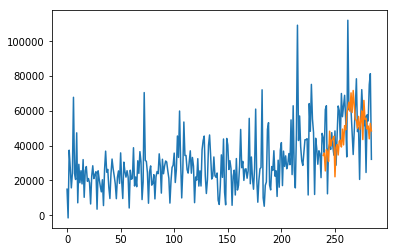

In [46]:
# Let's now plot the predicted values for the test set against the real values (and let's do the same for the training set, why not :-) ))
predictTraining = model3.predict(dependentTrain)
predictTest = model3.predict(dependentTest)


# We new get the predictions back to the original scale:
predictTraining = scaler.inverse_transform(predictTraining)
targetTrain = scaler.inverse_transform(targetTrain)
predictTest = scaler.inverse_transform(predictTest)
targetTest = scaler.inverse_transform(targetTest)






# calculate root mean squared error
print(math.sqrt(mean_squared_error(targetTrain, predictTraining[:,0]))) 
print(math.sqrt(mean_squared_error(targetTest, predictTest[:,0])))
# far from perfect, but actually not that bad if we consider that we didn't fine-tune the parameters at all and that we didn't consider any other variable
# except for the "sales amount per day"



# Let's now plot the predictions vs the actual sales amounts:
testPlot = np.empty_like(data)
testPlot[:, :] = np.nan
testPlot[len(testPlot)+-len(predictTest):len(testPlot), :] = predictTest
plt.plot(data['Amount'].values)
plt.plot(testPlot)
plt.show()

In [ ]:
# We didn't manage to pick up the sudden increase around mid November or the sudden "spikes"
#, but the predictions don't seem to be totally off, especially if we consider that there was a possible
# trend reversal or "regime change" during November/December.  

In [47]:
###### Let's now build the final model #########
scaler = MinMaxScaler(feature_range=(0, 1))
trainAll = scaler.fit_transform(data['Amount'].values.reshape(-1,1))
history = 10      
dependentTrainAll, targetTrainAll = reshape_data(train, history)
dependentTrainAll = np.reshape(dependentTrainAll, (dependentTrainAll.shape[0], 1, dependentTrainAll.shape[1]))
model3.fit(dependentTrainAll, targetTrainAll, epochs=1000, batch_size=30, verbose=2,  shuffle=False)


Epoch 1/1000
 - 0s - loss: 0.0094
Epoch 2/1000
 - 0s - loss: 0.0094
Epoch 3/1000
 - 0s - loss: 0.0094
Epoch 4/1000
 - 0s - loss: 0.0094
Epoch 5/1000
 - 0s - loss: 0.0094
Epoch 6/1000
 - 0s - loss: 0.0094
Epoch 7/1000
 - 0s - loss: 0.0094
Epoch 8/1000
 - 0s - loss: 0.0094
Epoch 9/1000
 - 0s - loss: 0.0094
Epoch 10/1000
 - 0s - loss: 0.0094
Epoch 11/1000
 - 0s - loss: 0.0094
Epoch 12/1000
 - 0s - loss: 0.0094
Epoch 13/1000
 - 0s - loss: 0.0094
Epoch 14/1000
 - 0s - loss: 0.0094
Epoch 15/1000
 - 0s - loss: 0.0094
Epoch 16/1000
 - 0s - loss: 0.0094
Epoch 17/1000
 - 0s - loss: 0.0094
Epoch 18/1000
 - 0s - loss: 0.0094
Epoch 19/1000
 - 0s - loss: 0.0094
Epoch 20/1000
 - 0s - loss: 0.0094
Epoch 21/1000
 - 0s - loss: 0.0094
Epoch 22/1000
 - 0s - loss: 0.0094
Epoch 23/1000
 - 0s - loss: 0.0094
Epoch 24/1000
 - 0s - loss: 0.0094
Epoch 25/1000
 - 0s - loss: 0.0093
Epoch 26/1000
 - 0s - loss: 0.0093
Epoch 27/1000
 - 0s - loss: 0.0093
Epoch 28/1000
 - 0s - loss: 0.0093
Epoch 29/1000
 - 0s - loss: 0

Epoch 232/1000
 - 0s - loss: 0.0088
Epoch 233/1000
 - 0s - loss: 0.0088
Epoch 234/1000
 - 0s - loss: 0.0088
Epoch 235/1000
 - 0s - loss: 0.0088
Epoch 236/1000
 - 0s - loss: 0.0088
Epoch 237/1000
 - 0s - loss: 0.0088
Epoch 238/1000
 - 0s - loss: 0.0088
Epoch 239/1000
 - 0s - loss: 0.0088
Epoch 240/1000
 - 0s - loss: 0.0088
Epoch 241/1000
 - 0s - loss: 0.0088
Epoch 242/1000
 - 0s - loss: 0.0088
Epoch 243/1000
 - 0s - loss: 0.0088
Epoch 244/1000
 - 0s - loss: 0.0088
Epoch 245/1000
 - 0s - loss: 0.0088
Epoch 246/1000
 - 0s - loss: 0.0088
Epoch 247/1000
 - 0s - loss: 0.0088
Epoch 248/1000
 - 0s - loss: 0.0088
Epoch 249/1000
 - 0s - loss: 0.0088
Epoch 250/1000
 - 0s - loss: 0.0088
Epoch 251/1000
 - 0s - loss: 0.0087
Epoch 252/1000
 - 0s - loss: 0.0087
Epoch 253/1000
 - 0s - loss: 0.0087
Epoch 254/1000
 - 0s - loss: 0.0087
Epoch 255/1000
 - 0s - loss: 0.0087
Epoch 256/1000
 - 0s - loss: 0.0087
Epoch 257/1000
 - 0s - loss: 0.0087
Epoch 258/1000
 - 0s - loss: 0.0087
Epoch 259/1000
 - 0s - loss:

Epoch 460/1000
 - 0s - loss: 0.0082
Epoch 461/1000
 - 0s - loss: 0.0082
Epoch 462/1000
 - 0s - loss: 0.0082
Epoch 463/1000
 - 0s - loss: 0.0082
Epoch 464/1000
 - 0s - loss: 0.0082
Epoch 465/1000
 - 0s - loss: 0.0082
Epoch 466/1000
 - 0s - loss: 0.0082
Epoch 467/1000
 - 0s - loss: 0.0082
Epoch 468/1000
 - 0s - loss: 0.0082
Epoch 469/1000
 - 0s - loss: 0.0082
Epoch 470/1000
 - 0s - loss: 0.0082
Epoch 471/1000
 - 0s - loss: 0.0081
Epoch 472/1000
 - 0s - loss: 0.0081
Epoch 473/1000
 - 0s - loss: 0.0081
Epoch 474/1000
 - 0s - loss: 0.0081
Epoch 475/1000
 - 0s - loss: 0.0081
Epoch 476/1000
 - 0s - loss: 0.0081
Epoch 477/1000
 - 0s - loss: 0.0081
Epoch 478/1000
 - 0s - loss: 0.0081
Epoch 479/1000
 - 0s - loss: 0.0081
Epoch 480/1000
 - 0s - loss: 0.0081
Epoch 481/1000
 - 0s - loss: 0.0081
Epoch 482/1000
 - 0s - loss: 0.0081
Epoch 483/1000
 - 0s - loss: 0.0081
Epoch 484/1000
 - 0s - loss: 0.0081
Epoch 485/1000
 - 0s - loss: 0.0081
Epoch 486/1000
 - 0s - loss: 0.0081
Epoch 487/1000
 - 0s - loss:

Epoch 688/1000
 - 0s - loss: 0.0077
Epoch 689/1000
 - 0s - loss: 0.0077
Epoch 690/1000
 - 0s - loss: 0.0077
Epoch 691/1000
 - 0s - loss: 0.0077
Epoch 692/1000
 - 0s - loss: 0.0077
Epoch 693/1000
 - 0s - loss: 0.0076
Epoch 694/1000
 - 0s - loss: 0.0076
Epoch 695/1000
 - 0s - loss: 0.0076
Epoch 696/1000
 - 0s - loss: 0.0076
Epoch 697/1000
 - 0s - loss: 0.0076
Epoch 698/1000
 - 0s - loss: 0.0076
Epoch 699/1000
 - 0s - loss: 0.0076
Epoch 700/1000
 - 0s - loss: 0.0076
Epoch 701/1000
 - 0s - loss: 0.0076
Epoch 702/1000
 - 0s - loss: 0.0076
Epoch 703/1000
 - 0s - loss: 0.0076
Epoch 704/1000
 - 0s - loss: 0.0076
Epoch 705/1000
 - 0s - loss: 0.0076
Epoch 706/1000
 - 0s - loss: 0.0076
Epoch 707/1000
 - 0s - loss: 0.0076
Epoch 708/1000
 - 0s - loss: 0.0076
Epoch 709/1000
 - 0s - loss: 0.0076
Epoch 710/1000
 - 0s - loss: 0.0076
Epoch 711/1000
 - 0s - loss: 0.0076
Epoch 712/1000
 - 0s - loss: 0.0076
Epoch 713/1000
 - 0s - loss: 0.0076
Epoch 714/1000
 - 0s - loss: 0.0076
Epoch 715/1000
 - 0s - loss:

Epoch 916/1000
 - 0s - loss: 0.0073
Epoch 917/1000
 - 0s - loss: 0.0073
Epoch 918/1000
 - 0s - loss: 0.0073
Epoch 919/1000
 - 0s - loss: 0.0073
Epoch 920/1000
 - 0s - loss: 0.0073
Epoch 921/1000
 - 0s - loss: 0.0073
Epoch 922/1000
 - 0s - loss: 0.0073
Epoch 923/1000
 - 0s - loss: 0.0073
Epoch 924/1000
 - 0s - loss: 0.0073
Epoch 925/1000
 - 0s - loss: 0.0073
Epoch 926/1000
 - 0s - loss: 0.0073
Epoch 927/1000
 - 0s - loss: 0.0073
Epoch 928/1000
 - 0s - loss: 0.0073
Epoch 929/1000
 - 0s - loss: 0.0073
Epoch 930/1000
 - 0s - loss: 0.0073
Epoch 931/1000
 - 0s - loss: 0.0073
Epoch 932/1000
 - 0s - loss: 0.0073
Epoch 933/1000
 - 0s - loss: 0.0073
Epoch 934/1000
 - 0s - loss: 0.0073
Epoch 935/1000
 - 0s - loss: 0.0073
Epoch 936/1000
 - 0s - loss: 0.0073
Epoch 937/1000
 - 0s - loss: 0.0073
Epoch 938/1000
 - 0s - loss: 0.0073
Epoch 939/1000
 - 0s - loss: 0.0073
Epoch 940/1000
 - 0s - loss: 0.0073
Epoch 941/1000
 - 0s - loss: 0.0073
Epoch 942/1000
 - 0s - loss: 0.0073
Epoch 943/1000
 - 0s - loss:

#############################

#############################

##### Predicting 2012
#############################

#############################

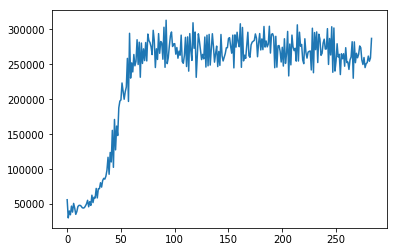

In [119]:
######### We'll just assume that there are 285 business days (as in 2011) :
#we're using the daily predictions as input for the prediction of the next day

random.seed(15)
#getting the prediction for day 1:
salesPredictedNextYear = []

previousDay = dependentTrainAll[-1] 

# we're adding some random noise in order to account for the uncertainty of the future demand
for i in range(0,284):
    inputFeatures = np.reshape(previousDay, (previousDay.shape[0], 1, previousDay.shape[1]))
    salesNextDay = model3.predict(inputFeatures)* float(1+np.random.uniform(-0.1,0.1,1))
    salesPredictedNextYear.append(salesNextDay) 
    previousDay = np.append(previousDay,salesNextDay)
    previousDay = previousDay[1:11]
    previousDay = np.reshape(previousDay,(1,10))


plt.plot(scaler.inverse_transform(np.reshape(np.array(salesPredictedNextYear),(284,1))))
plt.show()


In [ ]:
#As we can see, the model predicts that the trend iniated in November and December will continue until 
#  March and April. Then sales stop growing and reach a new plateau.
#The growth rate at the beginning of the year might a bit too steep. This is something that we might want
# to adjust manually. The model is also not accounting for possible seasonality effects in November and December.
# This is something we'd probably have to adjust manually, too.

# We're also completely ignoring other important features, e.g. day of the week, month of the year, public holidays, holiday season,
# pay days, product categories, correlation among product categories, etc.
# We might also consider separate models for each country and product category.
# We might also consider different modeling techniques: multiple regression, prophet, etc.

# If we had more data, we should have also split the dataset into training, validation and test set.